In [1]:

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

current_dir = os.getcwd()
information_metrics_dir = os.path.dirname(current_dir)
sys.path.append(information_metrics_dir)

import src.utils.helper_functions as helper
import src.utils.normalizing_functions as norm
import src.wrappers.spatial_metrics_calcium_base as sm
import src.utils.bootstrapped_estimation as bootstrap

from src.data.data_loader import LoadData
from src.data.data_processing import ProcessData
from src.utils import pre_processing_functions as pre_process

%matplotlib widget


In [69]:
# Initialize loader
dataset = 'kinsky'
loader = LoadData(dataset)

# See what's available
# loader.list_available()
loader.show_jupyter_tree()


Dataset path resolved: /home/apolo/Documents/github_projects/information_metrics/data/kinsky


In [70]:
# Load kinsky session
data = loader.load(mouse_id=3, day=1, session=1)

x_coordinates = data['position']['x'].copy()
y_coordinates = data['position']['y'].copy()
time_vector = data['position']['time'].copy()
sampling_rate = data['sampling_rate']
environment_edges = data['environment_edges']
raw_signal = data['traces']['raw'].copy()
filtered_signal = data['traces']['filtered'].copy()
diff_signal = data['traces']['diff'].copy()
original_binary_signal = data['traces']['binary'].copy()


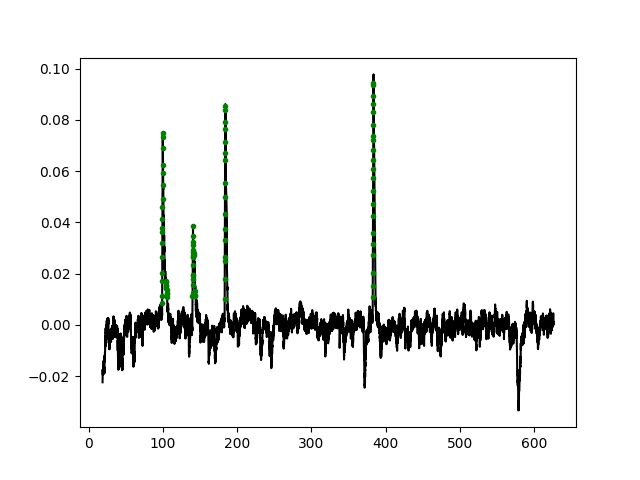

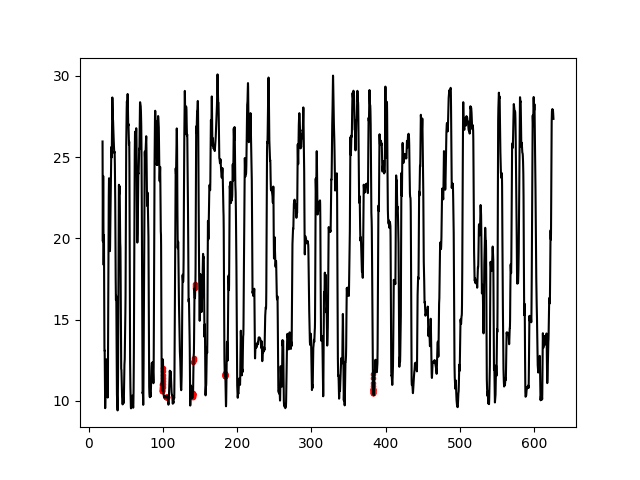

In [71]:
# Cells from fig 2C are 49,127,211,267 from
# data_dir = f"{project_root}/data/Kinsky/Mouse3 - G45/day 1/1 - square/"

# kinksy already provides a binary_signal. 
# But you can define your own using the pre_processing_functions.preprocess_signal

cell = 2
normalized_signal = norm.z_score_norm(filtered_signal[cell,:])
signal_type = 'filtered'

binary_signal = pre_process.preprocess_signal(normalized_signal, sampling_rate, 'binary', z_threshold = 1)

plt.figure()
plt.plot(time_vector,raw_signal[cell,:],'k')
plt.plot(time_vector[binary_signal==1],raw_signal[cell,:][binary_signal==1],'g.')

plt.show()

plt.figure()
plt.plot(time_vector,x_coordinates,'k',zorder = 5)
plt.plot(time_vector[binary_signal==1],x_coordinates[binary_signal==1],'r.')

plt.show()


In [73]:
# Now define your environment_edges
# You can think of it as a retangular box in cm.
# environment_edges = [[15,50],[35,70]]
environment_edges = [[5,35],[]]
environment_edges = [[5,35],[15,45]]

# in cm [[x_min,x_max],[y_min,y_max]]
# If you don`t set it, the program will use min and max coordinates as edges.


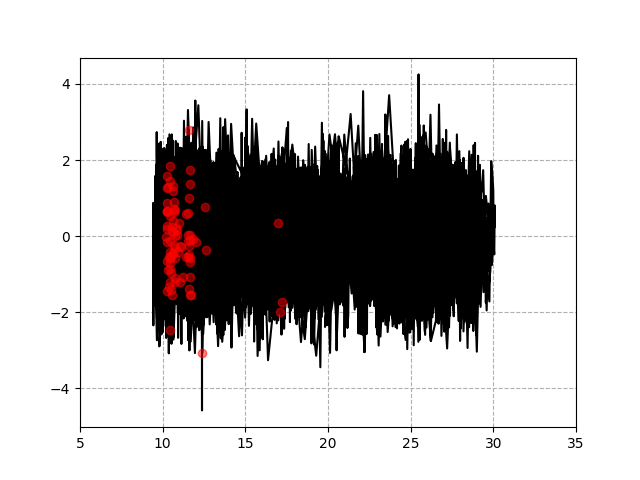

In [74]:
# And test it
x_coordinates_rand = np.random.randn(x_coordinates.shape[0])
plt.figure()
plt.plot(x_coordinates,x_coordinates_rand,'k',zorder = 5)
plt.scatter(x_coordinates[binary_signal==1],x_coordinates_rand[binary_signal==1],color = 'red', alpha=0.5, zorder = 10)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
# plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.grid(ls='--',zorder = 1)
plt.show()


In [60]:

# Create a dictionary to hold input parameters for further processing
input_dict = {

# Construct the filename and other identifiers for saving the results
'saving_string' : 'SpatialMetrics.' + signal_type,  # Filename prefix for saved results
'animal_id' : 'NeuronModel',  # Identifier for the animal or model
'dataset' : 'Simulation',  # Name of the dataset
'day' : 1,  # Day or session number
'neuron' : 1,  # Neuron identifier
'trial' : None,  # Trial identifier (optional, can be None)
'saving_path' : None,  # Directory path for saving results (optional, can be None)
'saving' : False,  # Flag indicating whether to save the results (False means no saving)
'overwrite': False, # Flag indicating whether to overwrite already saved file 
'signal_type' : signal_type,  # This is used to detect events. You can use any name for continuous data or "binary".
    
# Set inclusion criteria for the analysis
'min_time_spent' : 0.05,  # Minimum time an animal must spend in each xy bin in time_vector units (usually, in seconds). Kinsky et al. used 50 ms minimum occupancy 
'min_visits' : 0,  # Minimum number of visits required in each xy bin
'min_speed_threshold' : 1,  # Minimum speed threshold (in coordinate units [e.g., cm, pixels])
'speed_smoothing_sigma' : 0.5,  # Std of the gaussian smooth. Units is the same as time vector (seconds, for instance)

# Set parameters for plotting and information score from map
'x_bin_size' : 0.2,  # Size of x bins (in coordinate units [e.g., cm, pixels])
'y_bin_size' : 0.2,  # Size of y bins (in coordinate units [e.g., cm, pixels])
'map_smoothing_sigma_x' : 0.5,  # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps
'map_smoothing_sigma_y' : 0.5, # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps

# Set parameters for information calculation
'x_bin_size_info' : 4,  # Size of x bins (in coordinate units [e.g., cm, pixels])
'y_bin_size_info' : 4,  # Size of y bins (in coordinate units [e.g., cm, pixels])

# Set parameters for surrogate analysis
'shift_time' : 200,  # Time shift window in seconds for creating surrogate distributions
'num_cores' : -1,  # Number of CPU cores to use (set to -1 to use all available cores)
'num_surrogates' : 800,  # Number of surrogate distributions to generate

# Set parameters for place fields detection
'min_num_of_bins' : 1,  # Minimum number of spatial bins required to define a place field
'threshold': ('percentile',50),  # Method and value for detecting significant bins (e.g., 50th percentile of surrogates). 
# Options: ('mean_std',std deviations) or ('percentile',percentile)

# Set parameters for place fields extension
'threshold_fraction': 0.5, # fraction of the peak activity within each field to define the place field extension

'alpha' : 0.5  # Significance level for determining if a neuron is a place cell

}


cell = 2
normalized_signal = norm.z_score_norm(filtered_signal[cell,:])
normalized_signal = norm.min_max_norm(filtered_signal[cell,:])

signal_type = 'filtered'

# y_coordinates = None
signal_data = ProcessData(normalized_signal, x_coordinates, y_coordinates, time_vector, sampling_rate, environment_edges)

spatial_metrics = sm.PlaceCell(**input_dict)
spatial_metrics_output = spatial_metrics.main(signal_data)


Processing Surrogates:   0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

SpatialMetrics.filtered.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


In [77]:
# import numpy as np
# from sklearn.neighbors import NearestNeighbors
# from scipy.special import digamma
# from math import log2, e

# def ksg_mi(xy, calcium, k=3):
#     """
#     Estimate mutual information I([x, y]; calcium) using the
#     KSG “version 2” k-NN estimator, returning bits.
#     """
#     xy = np.asarray(xy)
#     z = np.asarray(calcium).reshape(-1, 1)
#     n_samples = xy.shape[0]
#     assert z.shape[0] == n_samples

#     # 1) joint space
#     joint = np.hstack((xy, z))

#     # 2) get distance-to-kth-neighbor in joint space
#     nn_joint = NearestNeighbors(n_neighbors=k+1, metric='chebyshev')
#     nn_joint.fit(joint)
#     dists, _ = nn_joint.kneighbors(joint)
#     eps = dists[:, k]    # treat this as ε_i

#     # 3) subtract tiny ε to make the marginal ball strictly exclude the k-th point
#     eps_safe = eps - np.finfo(float).eps

#     # 4) count marginal neighbors (vectorized)
#     nn_xy = NearestNeighbors(metric='chebyshev').fit(xy)
#     nn_z  = NearestNeighbors(metric='chebyshev').fit(z)

#     n_x = nn_xy.radius_neighbors(xy, radius=eps_safe, count_only=True) - 1
#     n_y = nn_z.radius_neighbors(z, radius=eps_safe, count_only=True) - 1

#     # 5) plug into version 2 formula: ψ(k) + ψ(N) − ⟨ψ(n_x+1)+ψ(n_y+1)⟩
#     mi_nats = digamma(k) + digamma(n_samples) - np.mean(digamma(n_x + 1) + digamma(n_y + 1))
#     return mi_nats * log2(e)


import numpy as np
from sklearn.neighbors import NearestNeighbors, BallTree
from scipy.special import digamma
from math import log2, e

def ksg_mi(xy, calcium, k=3):
    xy = np.asarray(xy)
    z  = np.asarray(calcium).reshape(-1, 1)
    N  = xy.shape[0]
    assert z.shape[0] == N

    # joint k-NN
    joint = np.hstack((xy, z))
    nnj = NearestNeighbors(n_neighbors=k+1, metric='chebyshev').fit(joint)
    dists, _ = nnj.kneighbors(joint)
    eps = dists[:, k] - np.finfo(float).eps  # subtract tiny ε

    # marginal counts via BallTree
    tree_xy = BallTree(xy, metric='chebyshev')
    tree_z  = BallTree(z,  metric='chebyshev')

    n_x = tree_xy.query_radius(xy, r=eps, count_only=True) - 1
    n_y = tree_z.query_radius(z,    r=eps, count_only=True) - 1

    # version-2 KSG
    mi_nats = digamma(k) + digamma(N) - np.nanmean(digamma(n_x+1) + digamma(n_y+1))
    return mi_nats * log2(e)



In [78]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from math import log2, e

def compare_mi(x, y, calcium, k=3, random_state=None, n_jobs=None):
    """
    Compare:
      - I((x,y);signal) estimated by your ksg_mi (in bits)
      - sum_j I(coord_j; signal) by mutual_info_regression

    Parameters
    ----------
    x, y : array-like, shape (n_samples,)
        Spatial coordinates.

    calcium : array-like, shape (n_samples,)
        Continuous signal.

    k : int, default=3
        Number of neighbors for both mi estimators.

    random_state : int or None
        Passed to mutual_info_regression.

    n_jobs : int or None
        Passed to mutual_info_regression.

    Returns
    -------
    mi_ksg_bits : float
        Your KSG estimate I((x,y);signal) in bits.

    mi_feats_bits : ndarray, shape (2,)
        [I(x;signal), I(y;signal)] from mutual_info_regression, in bits.

    mi_feats_sum_bits : float
        Sum of the above two — a rough proxy for the joint MI.
    """
    # stack coords
    xy = np.column_stack((x, y))

    # 1) your KSG-based function (returns bits)
    mi_ksg_bits = ksg_mi(xy, calcium, k=k)

    # 2) scikit-learn per-feature MI (nats → bits)
    mi_feats_nats = mutual_info_regression(
        xy, np.asarray(calcium),
        discrete_features=False,
        n_neighbors=k,
        random_state=random_state,
        n_jobs=n_jobs
    )
    mi_feats_bits = mi_feats_nats * log2(e)
    mi_feats_sum_bits = float(np.nansum(mi_feats_bits))

    return mi_ksg_bits, mi_feats_bits, mi_feats_sum_bits


In [90]:
# assume x, y, calcium are 1D numpy arrays
x = signal_data.x_coordinates
y = signal_data.y_coordinates
calcium  = signal_data.input_signal
mi_ksg, mi_xy_bits, mi_sum = compare_mi(x, y, calcium, k=5, random_state=0)

print(f"KSG joint MI ((x,y);calcium) = {mi_ksg:.4f} bits")
print(f"I(x;calcium) = {mi_xy_bits[0]:.4f} bits")
print(f"I(y;calcium) = {mi_xy_bits[1]:.4f} bits")
print(f"sum(I) ≈ {mi_sum:.4f} bits")


KSG joint MI ((x,y);calcium) = 1.4563 bits
I(x;calcium) = 0.4242 bits
I(y;calcium) = 0.4506 bits
sum(I) ≈ 0.8748 bits


In [82]:
mi_ksg

np.float64(1.4563279166045466)

In [43]:
xy = signal_data.x_coordinates.reshape(-1,1)
mi_val = ksg_mi(xy, signal_data.input_signal, k=3)
mi_val

np.float64(0.0057110105303445485)

In [47]:
xy = np.vstack((signal_data.x_coordinates, signal_data.x_coordinates)).T


In [48]:
mi_val = ksg_mi(xy, signal_data.input_signal, k=3)
mi_val

np.float64(0.0057110105303445485)

In [53]:
import numpy as np
from scipy.special import digamma
from sklearn.neighbors import BallTree
from sklearn.preprocessing import StandardScaler

def joint_mutual_info_ksg(x, y, signal, k=3):
    """
    Compute joint mutual information between 2D coordinates (x, y) 
    and a continuous signal using the KSG estimator.
    
    Parameters:
        x, y (array-like): 1D arrays of coordinates.
        signal (array-like): 1D array of calcium signals.
        k (int): Number of neighbors (default=3).
        
    Returns:
        mi (float): Estimated mutual information.
    """
    # Stack and standardize data
    X = np.column_stack((x, y))
    signal = signal.reshape(-1, 1)
    Z = np.hstack((X, signal))
    
    scaler = StandardScaler()
    Z_std = scaler.fit_transform(Z)
    
    n_samples = Z_std.shape[0]
    Z_joint = Z_std
    Z_xy = Z_std[:, :2]  # Spatial coordinates
    Z_signal = Z_std[:, 2:]  # Signal
    
    # Compute k-th neighbor distances in joint space (Chebyshev metric)
    tree_joint = BallTree(Z_joint, metric='chebyshev')
    dists, _ = tree_joint.query(Z_joint, k=k+1)  # Include self
    d_i = dists[:, -1]  # Distance to k-th neighbor (excl. self)
    
    # Trees for marginal spaces
    tree_xy = BallTree(Z_xy, metric='chebyshev')
    tree_signal = BallTree(Z_signal, metric='chebyshev')
    
    # Count neighbors within distance d_i in each marginal space
    n_xy = np.array([tree_xy.query_radius(point.reshape(1, -1), 
                     r=d_i[i], count_only=True) 
                     for i, point in enumerate(Z_xy)])
    n_signal = np.array([tree_signal.query_radius(point.reshape(1, -1), 
                         r=d_i[i], count_only=True) 
                         for i, point in enumerate(Z_signal)])
    
    # KSG estimator (version 2)
    mi = (
        digamma(k) 
        - 1/k 
        - np.nanmean(digamma(n_xy) + digamma(n_signal)) 
        + digamma(n_samples)
    )
    return max(0, mi)  # MI is non-negative


In [54]:

# Example usage:
# x, y: coordinates (1D arrays)
# signal: calcium signal (1D array)
mi_value = joint_mutual_info_ksg(signal_data.x_coordinates, signal_data.x_coordinates, signal_data.input_signal, k=3)
print(f"Joint Mutual Information: {mi_value:.4f}")

Joint Mutual Information: 0.0000


In [52]:
mi_value

0

In [21]:
spatial_metrics_output.keys()
spatial_metrics_output['mutual_info_pvalue']


np.float64(0.1972534332084894)

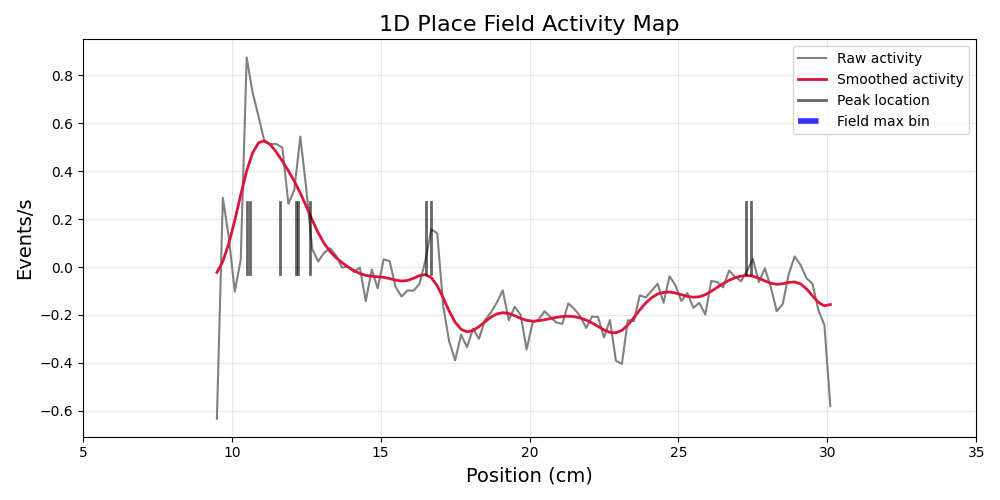

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot raw and smoothed activity
plt.plot(
    spatial_metrics_output['x_center_bins'],
    spatial_metrics_output['activity_map'],
    color='gray',
    label='Raw activity',
    linewidth=1.5
)

plt.plot(
    spatial_metrics_output['x_center_bins'],
    spatial_metrics_output['activity_map_smoothed'],
    color='crimson',
    label='Smoothed activity',
    linewidth=2
)

# Define tick height as a fraction of the map height
activity_min = np.nanmin(spatial_metrics_output['activity_map'])
activity_max = np.nanmax(spatial_metrics_output['activity_map'])
tick_height = (activity_max - activity_min) * 0.2  # 20% of total height
tick_center = activity_min + (activity_max - activity_min) * 0.5  # centered

# Plot short vertical lines at peak locations
for x in np.atleast_1d(spatial_metrics_output['peaks_x_location']):
    plt.plot(
        [x, x],
        [tick_center - tick_height / 2, tick_center + tick_height / 2],
        color='black',
        linestyle='-',
        linewidth=2,
        alpha=0.6,
        label='Peak location' if 'Peak location' not in plt.gca().get_legend_handles_labels()[1] else ""
    )

# Plot short vertical lines at field max bins
for x in np.atleast_1d(spatial_metrics_output['fields_x_max']):
    plt.plot(
        [x, x],
        [tick_center - tick_height / 2, tick_center + tick_height / 2],
        color='blue',
        linewidth=4,
        linestyle='--',
        alpha=0.8,
        label='Field max bin' if 'Field max bin' not in plt.gca().get_legend_handles_labels()[1] else ""
    )


bin_size = spatial_metrics_output['input_parameters']['x_bin_size']
activity_map = spatial_metrics_output['activity_map']
x_bins = spatial_metrics_output['x_center_bins']

# Shade place fields and annotate field IDs
if spatial_metrics_output['num_of_fields'] > 0:
    
    for field_id in spatial_metrics_output['field_ids']:
        field_spread = spatial_metrics_output['x_center_bins'][spatial_metrics_output['activity_map_identity'] == field_id]
        
        if field_spread.size == 1:
            center = field_spread[0]
            field_spread = np.array([center - bin_size, center + bin_size])
        
        plt.fill_between(
            spatial_metrics_output['x_center_bins'],
            spatial_metrics_output['activity_map_smoothed'],
            where=(spatial_metrics_output['x_center_bins'] >= field_spread[0]) &
                  (spatial_metrics_output['x_center_bins'] <= field_spread[-1]),
            color='tab:purple',
            alpha=0.5
        )
        
    # Get the y-position to place the label slightly above the max height in the field
    in_field = (spatial_metrics_output['x_center_bins'] >= field_spread[0]) & (spatial_metrics_output['x_center_bins'] <= field_spread[-1])
    y_pos = np.nanmax(spatial_metrics_output['activity_map_smoothed'][in_field])/2 # small offset
    
    # Center x-position
    x_center = np.mean(field_spread)
    
    plt.text(
        x_center,
        y_pos,
        f'{field_id}',
        ha='center',
        va='center',
        fontsize=30,
        color='black',
        weight='bold'
    )


# Final styling
plt.xlabel('Position (cm)', fontsize=14)
plt.ylabel('Events/s', fontsize=14)
plt.title('1D Place Field Activity Map', fontsize=16)
plt.xlim([signal_data.environment_edges[0][0], signal_data.environment_edges[0][1]])
plt.grid(alpha=0.3)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'black',label='Raw')
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed')
plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'black',label='Raw')
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed')
plt.plot([place_cell_output['x_peaks_location'],place_cell_output['x_peaks_location']],[np.nanmin(place_cell_output['place_field']),np.nanmax(place_cell_output['place_field'])],color = 'red',linestyle='--',alpha=0.2)
plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed_shifted'].T,color = 'black',alpha=0.1)
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed_shifted'][0,:],color = 'black',label='Smoothed shifted',alpha=0.1)
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed original')
plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_shifted'].T,color = 'black',alpha=0.1)
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_shifted'][0,:],color = 'black',label='Raw shifted',alpha=1)
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'red',label='Raw original')
plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

place_field_smoothed_shifted = place_cell_output['place_field_shifted'].copy()
place_field_smoothed = place_cell_output['place_field'].copy()
place_field_identity = place_cell_output['place_field_identity']

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_field_smoothed_shifted.T,'k',alpha=0.1)
plt.plot(place_cell_output['x_center_bins'],place_field_smoothed,'r')
plt.plot(place_cell_output['x_center_bins'],place_field_identity+0.5,'g.',markersize=10)
plt.show()


In [ ]:

place_field = place_cell_output['place_field'].copy()
place_field_smoothed = place_cell_output['place_field_smoothed'].copy()
place_field_identity = place_cell_output['place_field_identity']
x_center_bins = place_cell_output['x_center_bins']
islands_x_max = place_cell_output['islands_x_max']

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'black',label='Raw')
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed')
if islands_x_max.size>0:
    plt.plot(x_center_bins[islands_x_max],place_field_smoothed[islands_x_max],'g.',markersize=15)

plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.title('Number place fields = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)

plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:

place_field_identity = place_cell_output['place_field_identity']
x_center_bins = place_cell_output['x_center_bins']
islands_x_max = place_cell_output['islands_x_max']

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'black',label='Raw')
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed')
if islands_x_max.size>0:
    plt.plot(x_center_bins[islands_x_max],place_field_smoothed[islands_x_max],'g.',markersize=15)

plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.title('Number place fields = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)

for ii in range(place_cell_output['num_of_islands']):
    field_spread = place_cell_output['x_center_bins'][place_field_identity == ii]
    plt.fill_between(x_center_bins,place_cell_output['place_field_smoothed'],0,where = (x_center_bins >= field_spread[0]) & (x_center_bins <= field_spread[-1]),alpha=0.5)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:

place_field = place_cell_output['place_field'].copy()
place_field_smoothed = place_cell_output['place_field_smoothed'].copy()
place_field_identity = place_cell_output['place_field_identity']
x_center_bins = place_cell_output['x_center_bins']
islands_x_max = place_cell_output['islands_x_max']

plt.figure()
plt.plot(x_center_bins,place_field,'k')
plt.plot(x_center_bins,place_field_smoothed,'r')
if islands_x_max.size>0:
    plt.plot(x_center_bins[islands_x_max],place_field_smoothed[islands_x_max],'g.',markersize=15)

plt.title('Number place fields = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)

for ii in range(place_cell_output['num_of_islands']):
    field_spread = place_cell_output['x_center_bins'][place_field_identity == ii]
    plt.fill_between(x_center_bins,place_field,0,where = (x_center_bins >= field_spread[0]) & (x_center_bins <= field_spread[-1]))
plt.show()


In [ ]:
# Place field extension relative to the whole enviroment
place_cell_output['place_cell_extension_absolute']

In [ ]:
# Place field extension relative to enviroment occupancy
place_cell_output['place_cell_extension_relative']


In [ ]:
place_cell_output.keys()

In [ ]:
# p value is defined as the amount of shifted mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_shifted'] >= place_cell_output['mutual_info_original'])/place_cell_output['mutual_info_shifted'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_shifted'].shape[0]
p_value

counts,bins = np.histogram(place_cell_output['mutual_info_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_original'],place_cell_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.4f}".format(place_cell_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# p value is defined as the amount of shifted mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_NN_shifted'] >= place_cell_output['mutual_info_NN_original'])/place_cell_output['mutual_info_NN_shifted'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_NN_shifted'].shape[0]
p_value

counts,bins = np.histogram(place_cell_output['mutual_info_NN_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_NN_original'],place_cell_output['mutual_info_NN_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.4f}".format(place_cell_output['mutual_info_NN_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (nearest neighbors)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()
